In [1]:
!gdown "1ur4CrYKZT197pOCdZCSt-7DabXbcp-x_"

Downloading...
From: https://drive.google.com/uc?id=1ur4CrYKZT197pOCdZCSt-7DabXbcp-x_
To: /content/kaggle.json
100% 63.0/63.0 [00:00<00:00, 167kB/s]


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d rizkyyk/fastext-model-tweet

Dataset URL: https://www.kaggle.com/datasets/rizkyyk/fastext-model-tweet
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 99% 760M/765M [00:15<00:00, 63.8MB/s]
100% 765M/765M [00:15<00:00, 51.1MB/s]


In [4]:
!unzip fastext-model-tweet.zip -d /content/dataset

Archive:  fastext-model-tweet.zip
  inflating: /content/dataset/Fastext_model_tweet.bin  


In [5]:
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 1.6 MB/s eta 0:00:00


#Importing Library

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv
import numpy as np
import seaborn as sns
from time import time
import gensim
import nltk

from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Analysis Sentiment</p>

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">Table of Content</p>

* [1. Loading Data 💎](#1)
* [2. EDA 📊](#2)
* [3. Data Preprocessing ⚙️](#3)
    * [3.1 Cleaning the corpus 🛠](#3.1)
    * [3.2 Stemming 🛠](#3.2)
    * [3.3 All together 🛠](#3.3)
    * [3.4 Target encoding 🛠](#3.4)
* [4. Tokens visualization 📊](#4)
* [5. Vectorization](#5)
    * [5.1 Tunning CountVectorizer](#5.1)
    * [5.2 TF-IDF](#5.2)
    * [5.3 Word Embeddings: GloVe](#5.3)
* [6. Modeling](#6)
    * [6.1 Naive Bayes DTM](#6.1)
    * [6.2 Naive Bayes TF-IDF](#6.2)
    * [6.3 XGBoost](#6.3)
* [7. LSTM](#7)
* [8. BERT](#8)
* [9. NLP: Disaster tweets](#9)
    * [9.1 EDA](#9.1)
    * [9.2 Data preprocessing](#9.2)
    * [9.3 WordCloud](#9.3)
    * [9.4 Modeling](#9.4)
    * [9.5 GloVe - LSTM](#9.5)

<a id='1'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Loading Data 💎</p>

In [8]:
df1 = "https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/Twitter_Emotion_Dataset.csv"
df1 = pd.read_csv(df1, lineterminator="\n")
df1 = df1[['tweet','label']].rename(columns={'tweet':'Tweet'})
df1

,Tweet,label
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",anger
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",anger
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,happy
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",anger
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",happy
...,...,...
4396,"Tahukah kamu, bahwa saat itu papa memejamkan m...",love
4397,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,fear
4398,"5. masa depannya nggak jelas. lha iya, gimana ...",anger
4399,[USERNAME] dulu beneran ada mahasiswa Teknik U...,happy


In [9]:
# Mendefinisikan mapping dari emosi ke sentimen
emotion_to_sentiment = {
    'happy': 'positive',
    'love': 'positive',
    'anger': 'negative',
    'sadness': 'negative',
    'fear': 'negative'
}
# Mengubah label emosi menjadi label sentimen
df1['label'] = df1['label'].map(emotion_to_sentiment)
df1

,Tweet,label
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",negative
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",positive
...,...,...
4396,"Tahukah kamu, bahwa saat itu papa memejamkan m...",positive
4397,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,negative
4398,"5. masa depannya nggak jelas. lha iya, gimana ...",negative
4399,[USERNAME] dulu beneran ada mahasiswa Teknik U...,positive


In [10]:
df2 = pd.read_csv("https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/INA_TweetsPPKM_Labeled_Pure.csv", sep="\t")
df2.drop(columns=["Date", "User"], inplace=True)
df2.rename(columns={"sentiment": "label"}, inplace=True)
df2

,Tweet,label
0,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,Kementerian Agama menerbitkan Surat Edaran Nom...,1
...,...,...
23639,noelle loses a bet to akarsha and it somehow e...,1
23640,they call her... weekeeshee...\n#butterflysoup...,1
23641,"put out what you wanna see more of, amirite ga...",1
23642,"i don't need anybody, i'm fine here on my own\...",1


In [11]:
# Menghitung jumlah baris untuk setiap label
label_counts = df2['label'].value_counts()

# Mengambil 70% dari baris dengan label 'neutral'
neutral_rows = df2[df2['label'] == 1]
reduced_neutral_rows = neutral_rows.sample(n=int(len(neutral_rows)*0.3), random_state=1)

# Mengambil semua baris dengan label selain 'neutral'
other_rows = df2[df2['label'] != 1]

# Menggabungkan baris yang telah direduksi dengan baris lainnya
df2 = pd.concat([other_rows, reduced_neutral_rows])

df2

,Tweet,label
33,Karena stimulasi untuk #anakberkebutuhankhusus...,2
35,Hadir Kembali Boss!! MEGA WIN Dari https://t.c...,0
44,Hayolohhhhhhhhh... seneng kannnn??\n\n#covid19...,0
47,Thank You teman-teman dari #saganheritagehotel...,0
51,Ruwet Ruwet Ruwet inilah Negeri RuwetNesia. He...,0
...,...,...
5643,Satpol PP Sidak Pelaksanaan Sekolah Tatap Muka...,1
17877,Perlakuan Petugas PPKM Darurat ke Paspamres Da...,1
12817,Jadi di perpanjang atau stop sampai hari ini s...,1
4932,Polres Kepulauan Seribu Terus bagikan masker d...,1


In [12]:
number_to_sentiment = {
    0: 'positive',
    1: 'neutral',
    2: 'negative'
}
df2['label'] = df2['label'].map(number_to_sentiment)
df2

,Tweet,label
33,Karena stimulasi untuk #anakberkebutuhankhusus...,negative
35,Hadir Kembali Boss!! MEGA WIN Dari https://t.c...,positive
44,Hayolohhhhhhhhh... seneng kannnn??\n\n#covid19...,positive
47,Thank You teman-teman dari #saganheritagehotel...,positive
51,Ruwet Ruwet Ruwet inilah Negeri RuwetNesia. He...,positive
...,...,...
5643,Satpol PP Sidak Pelaksanaan Sekolah Tatap Muka...,neutral
17877,Perlakuan Petugas PPKM Darurat ke Paspamres Da...,neutral
12817,Jadi di perpanjang atau stop sampai hari ini s...,neutral
4932,Polres Kepulauan Seribu Terus bagikan masker d...,neutral


In [13]:
df = pd.concat([df1, df2], ignore_index=True)

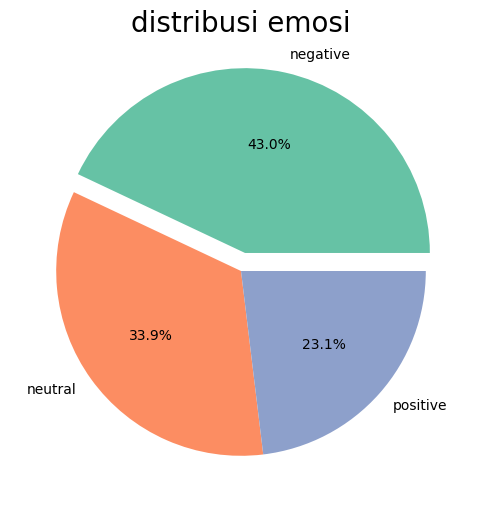

In [14]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in df['label'].value_counts()]
labels = list(df['label'].value_counts().index)
explode = (0.1, 0, 0)  # Offset the first segment
# Gunakan palet warna Seaborn
colors = sns.color_palette('Set2')
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, textprops={'fontsize': 10})
ax.set_title('distribusi emosi', fontsize = 20)
plt.show()

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. WordCLoud 📊</p>

In [ ]:
import requests
from PIL import Image
from io import BytesIO

url = "https://image.freepik.com/free-icon/twitter-logo_318-40459.jpg"  # replace with your image URL
response = requests.get(url)
twitter_mask = np.array(Image.open(BytesIO(response.content)))

wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'positive', 'Tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for positive tweet',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'negative', 'Tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'neutral', 'Tweet_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for SPAM messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [15]:
stopword_bahasa = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/stopwordbahasa.csv', encoding='latin-1')
stopword_bahasa = stopword_bahasa.rename(columns={0: 'stop'})
stopword_bahasa.head()

,ada
0,adalah
1,adanya
2,adapun
3,agak
4,agaknya


In [16]:
kamus_alay = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/kamus_alay.csv', header=None, encoding='latin-1')
kamus_alay = kamus_alay.rename(columns={0: 'original',
                                     1: 'replacement'})
kamus_alay_map = dict(zip(kamus_alay['original'], kamus_alay['replacement']))
kamus_alay.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [17]:
kamus_singkatan = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/kamus_singkatan.csv', sep=';', encoding='latin-1')
kamus_singkatan.columns = ['Column1', 'Column2']
kamus_singkatan = kamus_singkatan.rename(columns={'Column1': 'original', 'Column2': 'replacement'})
kamus_singkatan_map = dict(zip(kamus_singkatan['original'], kamus_singkatan['replacement']))
kamus_singkatan.head()

,original,replacement
0,adek,adik
1,adlh,adalah
2,aer,air
3,aiskrim,es krim
4,aj,saja


<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Cleaning 📊</p>

In [18]:
def remove_unnecessary_char(text):
    text = text.lower()
    text = re.sub('\n', ' ', text) # Remove every newline character
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Remove every username
    text = re.sub('user', ' ', text) # Remove every occurrence of the word 'user'
    text = re.sub('rt', ' ', text) # Remove every retweet symbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Remove every URL
    text = re.sub('https?://t\.me/[^\s]+', ' ', text) # Remove every Telegram link
    text = re.sub ('[^0-9a-zA-Z]+', ' ', text) # Remove every non-alphanumeric character
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
df["cleaning"] = df.Tweet.apply(lambda text: remove_unnecessary_char(text))
df.head(3)

,Tweet,label,cleaning
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative,soal jln jatibaru polisi tdk bs ge ak gubernur...
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative,sesama cewe lho kayaknya harusnya bisa lebih r...
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive,kepingin gudeg mbarek bu hj amad foto dari goo...


<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Preprocessing 📊</p>

In [19]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Text preprocessing functions from previous script
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text
def transform_emoticons(text):
    text = text.replace("<3", "<love>")
    text = text.replace(":p", "<mengejek>")
    text = text.replace(":P", "<mengejek>")
    text = text.replace(":v", "<melucu>")
    text = text.replace(":V", "<melucu>")
    text = text.replace(":d", "<tertawa>")
    text = text.replace(":D", "<tertawa>")
    text = text.replace(":-D", "<tertawa>")
    text = text.replace(":o", "<terkejut>")
    text = text.replace(":O", "<terkejut>")
    text = text.replace("xD", "<tertawa terbahak bahak>")
    text = text.replace("XD", "<tertawa terbahak bahak>")
    text = text.replace(":*", "<mencium>")
    text = text.replace(":3", "<malu malu kucing>")
    text = text.replace("-__-", "<wajah datar>")
    text = text.replace("-_-", "<wajah datar>")
    text = text.replace(":|", "<wajah datar>")
    text = text.replace(":\\", "<terganggu>")
    text = text.replace(":/", "<terganggu>")
    text = text.replace(":))", "<senyum>")
    text = text.replace(":)", "<senyum>")
    text = text.replace(":-))", "<senyum>")
    text = text.replace(":-)", "<senyum>")
    text = text.replace("^^", "<senyum>")
    text = text.replace("^_^", "<senyum>")
    text = text.replace(";))", "<senyum berkedip>")
    text = text.replace(";)", "<senyum berkedip>")
    text = text.replace(":((", "<sedih>")
    text = text.replace(":(", "<sedih>")
    text = text.replace(":-((", "<sedih>")
    text = text.replace(":-(", "<sedih>")
    text = text.replace(":'((", "<menangis sedih>")
    text = text.replace(":'(", "<menangis sedih>")
    text = text.replace(":'))", "<menangis bahagia>")
    text = text.replace(":')", "<menangis bahagia>")
    text = text.replace(":'", "<menangis sedih>")
    text = text.replace(":’((", "<menangis sedih>")
    text = text.replace(":’(", "<menangis sedih>")
    text = text.replace(":’))", "<menangis bahagia>")
    text = text.replace(":’)", "<menangis bahagia>")
    text = text.replace(":’", "<menangis sedih>")
    text = text.replace(":\"((", "<menangis sedih>")
    text = text.replace(":\"(", "<menangis sedih>")
    text = text.replace(":\"))", "<menangis bahagia>")
    text = text.replace(":\")", "<menangis bahagia>")
    text = text.replace(":\"", "<menangis sedih>")
    text = text.replace(":\"D", "<menangis bahagia>")
    text = text.replace("TT", "<menangis sedih>")
    return text

def normalize_alay(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

def normalize_singkatan(text):
    return ' '.join([kamus_singkatan_map[word] if word in kamus_singkatan_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join([ ' ' if word in stopword_bahasa.ada.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  return do

# Modified clean_text function that calls preprocessing functions from previous script
def preprocess(text):
    text = normalize_alay(text) # Normalize text using alay_dict_map
    text = normalize_singkatan(text) # Normalize text using alay_dict_map2
    text = remove_stopword(text) # Remove stopwords from text
    text = tokenizingText(text)
    text = stemming(text)
    return text
# df['preprocessing'] = df['cleaning'].apply(preprocess)
# df

In [28]:
# Apply data processing to each tweet
X = list(map(preprocess, df['cleaning']))

In [29]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['label'])

In [30]:
print(X[10])
print(Y[10])

['min', 'rakyat', 'indonesia', 'harap', 'nya', 'tinggal', 'tentara', 'nasional', 'indonesia', 'lihat', 'serang', 'kantor', 'media', 'ada', 'unsur', 'pidana', 'hina', 'presiden', 'indonesia', 'sah', 'lucu', 'lucu', 'an', 'tentara', 'nasional', 'indonesia', 'uniform', 'resource', 'locator']
0


In [31]:
y = pd.get_dummies(df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Ekstraksi Feature 📊</p>

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x)
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


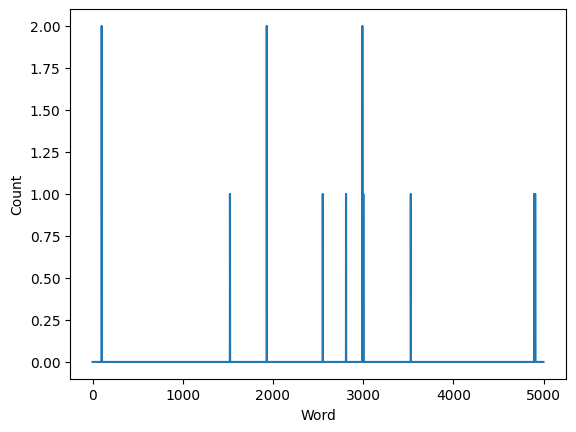

In [34]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Tokenize n Padding 📊</p>

In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleaning'][0])
X, tokenizer = tokenize_pad_sequences(df['cleaning'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 soal jln jatibaru polisi tdk bs ge ak gubernur emangny polisi tdk ikut pmbhasan jgn berpolitik pengaturan wilayah hak gubernur persoalan tn abang soal turun temurun pelik perlu kesabaran name name url 
After Tokenization & Padding 
 [ 420 1342  591  187  694 3693 1739  505  591  187  382  572 4415  154
 1458  505 4023 1309  420  271  239 2681    9    9   68    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [36]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [37]:
y = pd.get_dummies(df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (9390, 50) (9390, 3)
Validation Set -> (3130, 50) (3130, 3)
Test Set -> (3130, 50) (3130, 3)


In [38]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Modelling 📊</p>

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers.schedules import ExponentialDecay
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

# Membuat jadwal learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9)

# Membuat optimizer
sgd = SGD(learning_rate=lr_schedule, momentum=momentum, nesterov=False)

# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))


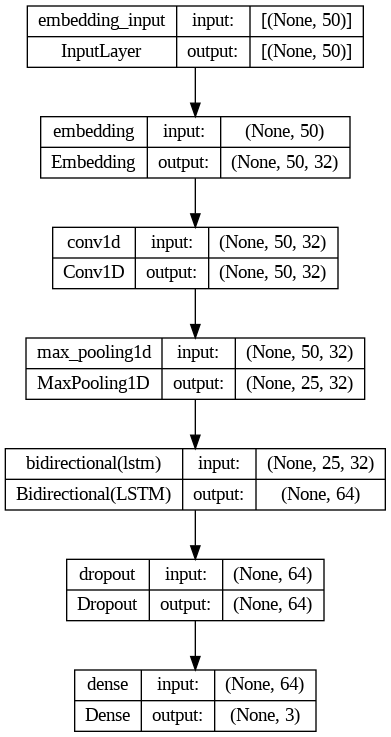

In [40]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [41]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

In [42]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.7700
Precision : 0.7719
Recall    : 0.7655
F1 Score  : 0.7687


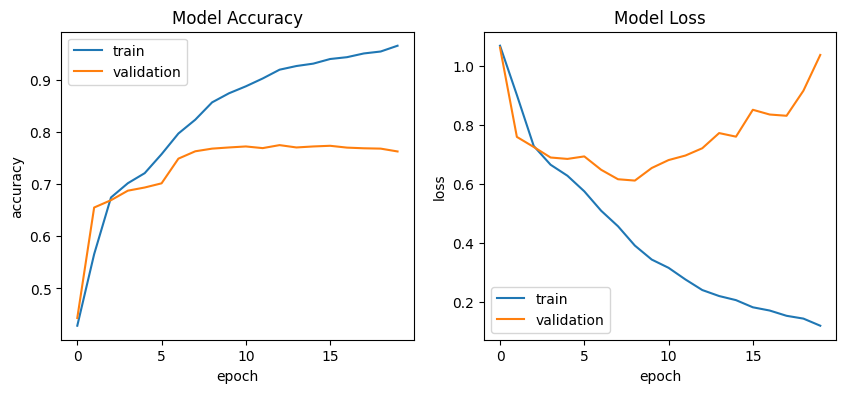

In [43]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

98/98 [==============================] - 1s 7ms/step


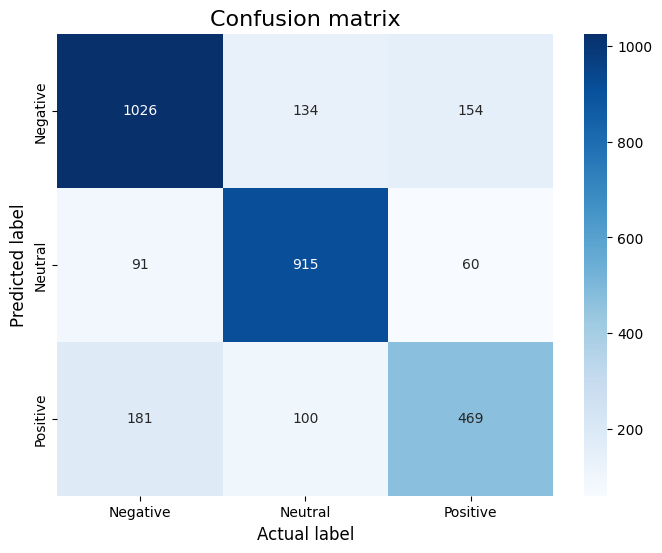

In [44]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

In [75]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [76]:
from keras.models import load_model

# Load model
model = load_model('/content/best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50

    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [84]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Load the scraped data
data_scrape = pd.read_csv('https://raw.githubusercontent.com/rizkyyanuark/College/main/datamining/combined.csv')
data_scrape = data_scrape[['created_at', 'full_text']].rename(columns={'created_at': 'date', 'full_text': 'tweet'}).drop_duplicates()
data_scrape


,date,tweet
0,Tue Apr 30 13:29:57 +0000 2024,selain kasus salah sasaran kipk ada jg yg dise...
1,Tue Apr 30 13:29:17 +0000 2024,Makin banyak yang ke spill yang kipk tapi tern...
2,Tue Apr 30 13:26:44 +0000 2024,@personality404_ the thing isss apakah that in...
3,Tue Apr 30 13:26:10 +0000 2024,Banyak amat kipk salah sasaran inimah yg salah...
4,Tue Apr 30 13:24:13 +0000 2024,@boomboomna @undipmenfess ini undip bnyk bener...
...,...,...
4026,Mon Apr 29 10:41:01 +0000 2024,@markfsoul mmf zan tapi aku bukan penerima kip...
4027,Mon Apr 29 10:40:46 +0000 2024,@digidegu Ohhh gini kelakukan penerima KIPK go...
4028,Mon Apr 29 10:39:47 +0000 2024,Itu penerima kipk di kuliti habis2an sampe dia...
4029,Mon Apr 29 10:39:40 +0000 2024,Penerima kipk kan dah ada indikatornya ya... k...


In [85]:
# Apply the preprocessing function to the 'tweet' column
data_scrape['processed_tweet'] = data_scrape['tweet'].apply(preprocess)

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='OOV')
tokenizer.fit_on_texts(data_scrape['processed_tweet'])

# Transform the tweets to sequences
sequences = tokenizer.texts_to_sequences(data_scrape['processed_tweet'])

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post')

# Predict the sentiment
predictions = model.predict(padded_sequences).argmax(axis=1)

# Map the prediction labels
sentiment_classes = ['Negative', 'Neutral', 'Positive']
predicted_labels = [sentiment_classes[prediction] for prediction in predictions]

# Add the predicted labels to the dataframe
data_scrape['label'] = predicted_labels

# Save the dataframe to a new CSV file
data_scrape.to_csv('your_scraped_file_with_predictions.csv', index=False)

124/124 [==============================] - 1s 5ms/step


In [83]:
predict_class([''])

1/1 [==============================] - 0s 122ms/step
The predicted sentiment is Neutral


<a id='4'></a>
# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. test model dengan data test scraping 📊</p>

In [ ]:
file_loc = "https://raw.githubusercontent.com/rizkyyanuark/College/main/datamining/combined.csv"
data_scrape = pd.read_csv(file_loc)
data_scrape

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1785300561094644037,Tue Apr 30 13:29:57 +0000 2024,0,selain kasus salah sasaran kipk ada jg yg dise...,1785300561094644037,NaN,NaN,in,NaN,0,0,0,https://twitter.com/jiegree/status/17853005610...,1344526407938916357,jiegree
1,1785300394010452166,Tue Apr 30 13:29:17 +0000 2024,0,Makin banyak yang ke spill yang kipk tapi tern...,1785300394010452166,NaN,NaN,in,Johnny,0,0,0,https://twitter.com/whosrahmah/status/17853003...,1187581909267701761,whosrahmah
2,1785253406166393056,Tue Apr 30 13:26:44 +0000 2024,0,@personality404_ the thing isss apakah that in...,1785299751065485367,NaN,personality404_,in,NaN,0,0,0,https://twitter.com/gagagagawrra/status/178529...,1662451301547118592,gagagagawrra
3,1785299607414886693,Tue Apr 30 13:26:10 +0000 2024,0,Banyak amat kipk salah sasaran inimah yg salah...,1785299607414886693,NaN,NaN,in,♡,0,0,0,https://twitter.com/samohaec/status/1785299607...,1734519974390317056,samohaec
4,1785270395622539737,Tue Apr 30 13:24:13 +0000 2024,0,@boomboomna @undipmenfess ini undip bnyk bener...,1785299116396102054,NaN,boomboomna,in,NaN,0,1,0,https://twitter.com/Nazifamulya/status/1785299...,1160811689937235968,Nazifamulya
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,1784890813501391093,Mon Apr 29 10:41:01 +0000 2024,0,@markfsoul mmf zan tapi aku bukan penerima kip...,1784895657053913391,NaN,markfsoul,in,Jakarta Selatan,0,1,0,https://twitter.com/ssenabluu/status/178489565...,2397505423,ssenabluu
4027,1328338212721311746,Mon Apr 29 10:40:46 +0000 2024,1,@digidegu Ohhh gini kelakukan penerima KIPK go...,1784895594584031590,NaN,digidegu,in,NaN,1,1,0,https://twitter.com/if_amall/status/1784895594...,1668011559547961344,if_amall
4028,1784895346692554790,Mon Apr 29 10:39:47 +0000 2024,0,Itu penerima kipk di kuliti habis2an sampe dia...,1784895346692554790,NaN,NaN,in,NaN,0,0,0,https://twitter.com/PMunceri/status/1784895346...,1784001049818505216,PMunceri
4029,1784895317474730334,Mon Apr 29 10:39:40 +0000 2024,0,Penerima kipk kan dah ada indikatornya ya... k...,1784895317474730334,NaN,NaN,in,NaN,0,1,0,https://twitter.com/ncddream/status/1784895317...,814624634498752512,ncddream


In [ ]:
data_scrape = data_scrape[['created_at', 'full_text']].rename(columns={'created_at': 'date', 'full_text': 'tweet'}).drop_duplicates()
data_scrape

,date,tweet
0,Tue Apr 30 13:29:57 +0000 2024,selain kasus salah sasaran kipk ada jg yg dise...
1,Tue Apr 30 13:29:17 +0000 2024,Makin banyak yang ke spill yang kipk tapi tern...
2,Tue Apr 30 13:26:44 +0000 2024,@personality404_ the thing isss apakah that in...
3,Tue Apr 30 13:26:10 +0000 2024,Banyak amat kipk salah sasaran inimah yg salah...
4,Tue Apr 30 13:24:13 +0000 2024,@boomboomna @undipmenfess ini undip bnyk bener...
...,...,...
4026,Mon Apr 29 10:41:01 +0000 2024,@markfsoul mmf zan tapi aku bukan penerima kip...
4027,Mon Apr 29 10:40:46 +0000 2024,@digidegu Ohhh gini kelakukan penerima KIPK go...
4028,Mon Apr 29 10:39:47 +0000 2024,Itu penerima kipk di kuliti habis2an sampe dia...
4029,Mon Apr 29 10:39:40 +0000 2024,Penerima kipk kan dah ada indikatornya ya... k...


In [ ]:
jumlah_tweet = data_scrape["tweet"].count()
print(f"Jumlah tweet: {jumlah_tweet}")
jumlah_nan = data_scrape.isnull().sum().sum()
print(f"Jumlah data NaN: {jumlah_nan}")

Jumlah tweet: 3938
Jumlah data NaN: 0


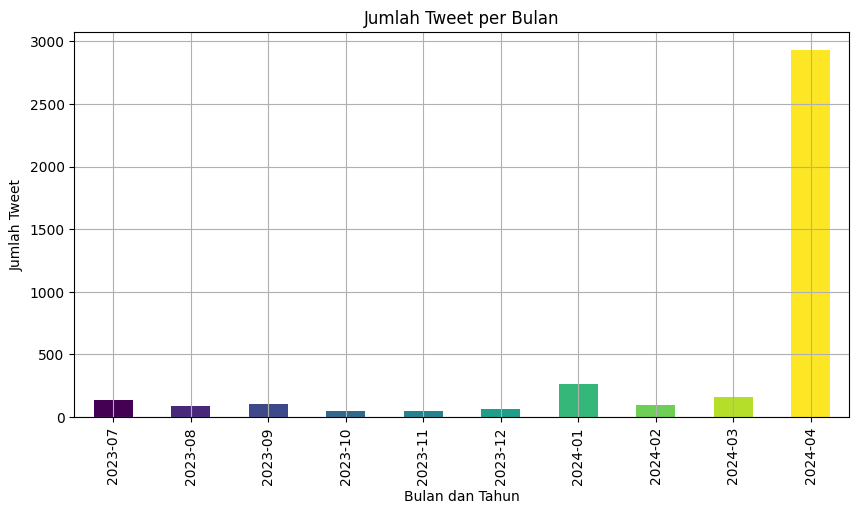

In [ ]:
tweets = data_scrape.copy()
tweets['date'] = pd.to_datetime(tweets['date'], format='%a %b %d %H:%M:%S +0000 %Y')
tweets['YearMonth'] = tweets['date'].dt.to_period('M')
monthly_tweets = tweets.groupby('YearMonth').size()
colors = plt.cm.viridis(np.linspace(0, 1, len(monthly_tweets)))
monthly_tweets.plot(kind='bar', figsize=(10, 5), color=colors)
plt.xlabel("Bulan dan Tahun")
plt.ylabel("Jumlah Tweet")
plt.title("Jumlah Tweet per Bulan")
plt.grid(True)
plt.show()
data_scrape = data_scrape[['tweet']]

In [ ]:
def lowercase(text):
    return text.lower()
data_scrape["cleaning"] = data_scrape.tweet.apply(lambda text: lowercase(text))
data_scrape.head(3)

In [ ]:
def remove_unnecessary_char(text):
    text = re.sub('\n', ' ', text) # Remove every newline character
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Remove every username
    text = re.sub('user', ' ', text) # Remove every occurrence of the word 'user'
    text = re.sub('rt', ' ', text) # Remove every retweet symbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Remove every URL
    text = re.sub('https?://t\.me/[^\s]+', ' ', text) # Remove every Telegram link
    text = re.sub ('[^0-9a-zA-Z]+', ' ', text) # Remove every non-alphanumeric character
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
data_scrape["cleaning"] = data_scrape.cleaning.apply(lambda text: remove_unnecessary_char(text))
data_scrape.head(3)

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Text preprocessing functions from previous script
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text
def transform_emoticons(text):
    text = text.replace("<3", "<love>")
    text = text.replace(":p", "<mengejek>")
    text = text.replace(":P", "<mengejek>")
    text = text.replace(":v", "<melucu>")
    text = text.replace(":V", "<melucu>")
    text = text.replace(":d", "<tertawa>")
    text = text.replace(":D", "<tertawa>")
    text = text.replace(":-D", "<tertawa>")
    text = text.replace(":o", "<terkejut>")
    text = text.replace(":O", "<terkejut>")
    text = text.replace("xD", "<tertawa terbahak bahak>")
    text = text.replace("XD", "<tertawa terbahak bahak>")
    text = text.replace(":*", "<mencium>")
    text = text.replace(":3", "<malu malu kucing>")
    text = text.replace("-__-", "<wajah datar>")
    text = text.replace("-_-", "<wajah datar>")
    text = text.replace(":|", "<wajah datar>")
    text = text.replace(":\\", "<terganggu>")
    text = text.replace(":/", "<terganggu>")
    text = text.replace(":))", "<senyum>")
    text = text.replace(":)", "<senyum>")
    text = text.replace(":-))", "<senyum>")
    text = text.replace(":-)", "<senyum>")
    text = text.replace("^^", "<senyum>")
    text = text.replace("^_^", "<senyum>")
    text = text.replace(";))", "<senyum berkedip>")
    text = text.replace(";)", "<senyum berkedip>")
    text = text.replace(":((", "<sedih>")
    text = text.replace(":(", "<sedih>")
    text = text.replace(":-((", "<sedih>")
    text = text.replace(":-(", "<sedih>")
    text = text.replace(":'((", "<menangis sedih>")
    text = text.replace(":'(", "<menangis sedih>")
    text = text.replace(":'))", "<menangis bahagia>")
    text = text.replace(":')", "<menangis bahagia>")
    text = text.replace(":'", "<menangis sedih>")
    text = text.replace(":’((", "<menangis sedih>")
    text = text.replace(":’(", "<menangis sedih>")
    text = text.replace(":’))", "<menangis bahagia>")
    text = text.replace(":’)", "<menangis bahagia>")
    text = text.replace(":’", "<menangis sedih>")
    text = text.replace(":\"((", "<menangis sedih>")
    text = text.replace(":\"(", "<menangis sedih>")
    text = text.replace(":\"))", "<menangis bahagia>")
    text = text.replace(":\")", "<menangis bahagia>")
    text = text.replace(":\"", "<menangis sedih>")
    text = text.replace(":\"D", "<menangis bahagia>")
    text = text.replace("TT", "<menangis sedih>")
    return text

def normalize_alay(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

def normalize_singkatan(text):
    return ' '.join([kamus_singkatan_map[word] if word in kamus_singkatan_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join([ ' ' if word in stopword_bahasa.ada.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  return d_clean

# Modified clean_text function that calls preprocessing functions from previous script
def preprocess(text):
    text = normalize_alay(text) # Normalize text using alay_dict_map
    text = normalize_singkatan(text) # Normalize text using alay_dict_map2
    text = remove_stopword(text) # Remove stopwords from text
    text = tokenizingText(text)
    text = stemming(text)
    return text
data_scrape['preprocessing'] = data_scrape['cleaning'].apply(preprocess)
data_scrape

In [ ]:
# Apply the preprocessing function to the 'tweet' column
data_scrape['processed_tweet'] = data_scrape['tweet'].apply(preprocess)

tokenizer = Tokenizer(num_words=5000, oov_token='OOV')
tokenizer.fit_on_texts(data_scrape['processed_tweet'])

sequences = tokenizer.texts_to_sequences(data_scrape['processed_tweet'])

padded_sequences = pad_sequences(sequences, maxlen=50, padding='post')

predictions = model.predict(padded_sequences).argmax(axis=1)

sentiment_classes = ['Negative', 'Neutral', 'Positive']
predicted_labels = [sentiment_classes[prediction] for prediction in predictions]

data_scrape['label'] = predicted_labels

# Save the dataframe to a new CSV file
data_scrape.to_csv('file_with_predictions.csv', index=False)

1/1 [==============================] - 1s 715ms/step


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in dataset['polarity'].value_counts()]
labels = list(dataset['polarity'].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 10})
ax.set_title('Sentiment Polarity on Twitter \n (total = 8021 comments)', fontsize = 11, pad = 20)
plt.show()